## Predict 1 week at a time for dates before 2016
1. Train model for 2 years
2. Predict 1 week via IncrementalModel
3. Repeat starting with next week

In [5]:
from BorderModel import run_Incremental, harmonic_mean
from BorderQuery import insert_predictions
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV
import datetime
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import copy
import pdb
from sklearn.metrics import r2_score
import cPickle as pickle

In [6]:
def create_train_test(date_end, test_days=7, train_years=2):
    '''
    IN 
        date_end: datetime.date of last day to predict
        duration: days to predict
        train_years: number of years to train
    '''
    train_start = date_end - datetime.timedelta(test_days + 366 * train_years)
    train_end = date_end - datetime.timedelta(test_days)
    test_start = date_end - datetime.timedelta(test_days)
    test_end = date_end
    return train_start, train_end, test_start, test_end
    
def run_multiweek(model, munger_id, crossing_id, first, last, test_days):
    prlist = {}
    test_date = first
    while test_date < last + datetime.timedelta(test_days):
        cpu = random.randint(0, 31)
        train_start, train_end, test_start, test_end = create_train_test(test_date, test_days=test_days)

        prlist[str(test_date)] = rc[cpu].apply_async(run_Incremental, model, munger_id, crossing_id,  
                                           train_start, train_end, 
                                           test_start, test_end)
        
        test_date += datetime.timedelta(test_days)
        
    return prlist

def score_df(models):
    predict = {date: model.score()['model'] for date, model in models.items()}
    ensemble = {date: model.score()['ensemble'] for date, model in models.items()}
    baseline = {date: model.score()['baseline'] for date, model in models.items()}
    
    df = pd.DataFrame([predict, ensemble, baseline]).T
    df.columns = ['predict', 'ensemble', 'baseline']
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df

def plot_scores(df):
    plt.figure(figsize=(16,4))
    plt.plot(df.baseline, label='baseline')
    plt.plot(df.predict, label='predict')
    plt.plot(df.ensemble, label='ensemble')
    plt.axhline(0, color='y')
    plt.legend();
    
def results_df(trained_models):
    predict = pd.Series().append([model.y_predict for key, model in trained_models.items()]).sort_index()
    ensemble = pd.Series().append([model.ensemble() for key, model in trained_models.items()]).sort_index()
    baseline = pd.Series().append([model.baseline() for key, model in trained_models.items()]).sort_index()
    actual = pd.Series().append([model.actual for key, model in trained_models.items()]).sort_index()
  
    df = pd.DataFrame()
    df['predict'] = predict
    df['ensemble'] = ensemble
    df['baseline'] = baseline
    df['actual'] = actual
    return df

def print_r2(results):
    actual = results.actual.dropna()
    print 'Predict: ', r2_score(actual, results.predict[actual.index])
    print 'Ensemble: ', r2_score(actual, results.ensemble[actual.index])
    print 'Baseline: ', r2_score(actual, results.baseline[actual.index])
    
# def get_trained(pr, first, last, test_days, exclude):
def get_trained(pr, exclude=[], wait=1):
    trained = {}
    for date in sorted(pr.keys()):
        if date not in [str(ex) for ex in exclude]:
            if pr[date].ready():
                trained[date] = pr[date].get(wait)
                print date, trained[date].score()
            else:
                print date, 'not ready'
            
    return trained


In [7]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 40)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    import datetime
    from BorderModel import run_Incremental
    from BorderQuery import select_features, select_mungedata_simple, select_mungedata
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.grid_search import GridSearchCV

importing datetime on engine(s)
importing run_Incremental from BorderModel on engine(s)
importing select_features,select_mungedata_simple,select_mungedata from BorderQuery on engine(s)
importing ExtraTreesRegressor from sklearn.ensemble on engine(s)
importing GridSearchCV from sklearn.grid_search on engine(s)


## Peace Arch South

### 2015

In [4]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

pr = run_multiweek(grid, 3, 1, datetime.date(2015, 1, 1), datetime.date(2016, 1, 1), 7)


In [6]:
exclude = []
trained = get_trained(pr, exclude)


2015-01-01 {'model': 0.41887178880672737, 'ensemble': 0.45527878478752337, 'baseline': 0.4953655728098576}
2015-01-08 {'model': 0.52917449414113626, 'ensemble': 0.4695540349277415, 'baseline': 0.3482164076815002}
2015-01-15 {'model': -1.3594574625341176, 'ensemble': -2.1988030157955953, 'baseline': -4.3948089687924909}
2015-01-22 {'model': -0.055306988257863399, 'ensemble': -0.54274383817338823, 'baseline': -1.7942496352676716}
2015-01-29 {'model': 0.13621705886523183, 'ensemble': -0.20823784912631749, 'baseline': -1.5500452984629245}
2015-02-05 {'model': 0.27949172071984951, 'ensemble': -0.24330652275781417, 'baseline': -2.7982134283227738}
2015-02-12 {'model': 0.62335515052050849, 'ensemble': 0.68604319885790566, 'baseline': 0.52540316434315615}
2015-02-19 {'model': 0.65371765614151878, 'ensemble': 0.58528305179359252, 'baseline': 0.20219806520563821}
2015-02-26 {'model': 0.57556228272911159, 'ensemble': 0.64902624591552782, 'baseline': 0.47332788089234268}
2015-03-05 {'model': 0.622

In [8]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.461480496718
Ensemble:  0.468262375098
Baseline:  0.353541947348


### 2014

In [7]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr1 = run_multiweek(grid, 3, 1, first, last, 7)


In [19]:
exclude = []
trained = get_trained(pr1, wait=0)


2014-01-01 {'model': 0.56036146726886171, 'ensemble': 0.5761902309975524, 'baseline': 0.61146059743264947}
2014-01-08 {'model': 0.5425383976252609, 'ensemble': 0.55993775269288837, 'baseline': 0.51422868976803038}
2014-01-15 {'model': -2.1848111560261834, 'ensemble': -2.863068298316469, 'baseline': -4.2707328678725531}
2014-01-22 {'model': 0.61465906997144737, 'ensemble': 0.61032127537561576, 'baseline': 0.44449685512174641}
2014-01-29 {'model': 0.44837576857464267, 'ensemble': 0.32136384806837337, 'baseline': -0.087001447126558551}
2014-02-05 {'model': 0.76655698130109862, 'ensemble': 0.7254028459892059, 'baseline': 0.51890564962789432}
2014-02-12 {'model': 0.69123498313440901, 'ensemble': 0.75515558415791451, 'baseline': 0.78655945008022798}
2014-02-19 {'model': 0.65325037875504888, 'ensemble': 0.61902207481090743, 'baseline': 0.5867179126823614}
2014-02-26 {'model': 0.42348009645431739, 'ensemble': 0.40325704367960591, 'baseline': 0.29547402196659822}
2014-03-05 {'model': 0.72580870

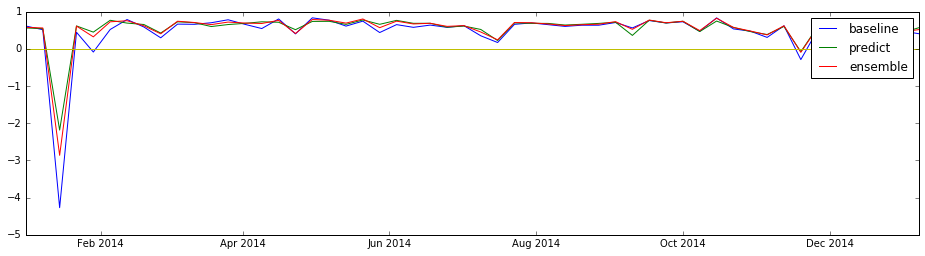

In [20]:
scores = score_df(trained)
plot_scores(scores)

In [21]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_1_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.626432446585
Ensemble:  0.627808509551
Baseline:  0.591258090505


## Pacific Highway South

### 2015

In [6]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})
first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)

pr5_15 = run_multiweek(grid, 3, 5, first, last, 7)


In [10]:
exclude = []

trained = get_trained(pr5_15, exclude)


2015-01-01 {'model': 0.54321718585857659, 'ensemble': 0.53209862004441222, 'baseline': 0.53360635276911372}
2015-01-08 {'model': 0.59822163632037817, 'ensemble': 0.53002586857209522, 'baseline': 0.42777892104205117}
2015-01-15 {'model': -0.87555783347283311, 'ensemble': -1.3767824885582387, 'baseline': -2.5594198289083412}
2015-01-22 {'model': 0.34631325226424325, 'ensemble': 0.034488643025669896, 'baseline': -0.71456686843956074}
2015-01-29 {'model': -0.061476703397673527, 'ensemble': -0.48287489992108257, 'baseline': -1.8131967463785328}
2015-02-05 {'model': 0.58199417631021144, 'ensemble': 0.33118149008898157, 'baseline': -1.2446526859107325}
2015-02-12 {'model': 0.60021632626690002, 'ensemble': 0.67687995554026137, 'baseline': 0.56255811702560932}
2015-02-19 {'model': 0.67687500670590572, 'ensemble': 0.5821189444978776, 'baseline': 0.15646585137301139}
2015-02-26 {'model': 0.62251089513382885, 'ensemble': 0.66658027835905043, 'baseline': 0.37507249104058504}
2015-03-05 {'model': 0.

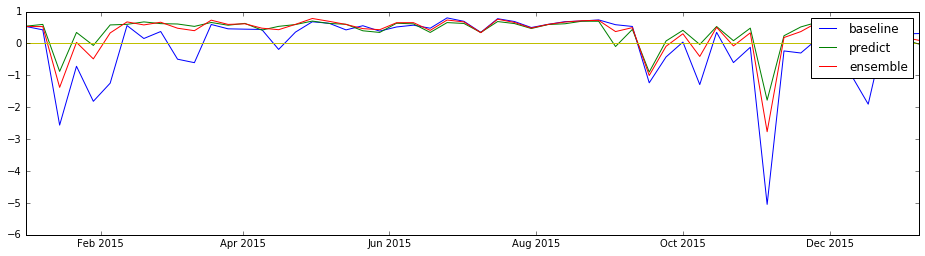

In [11]:
scores = score_df(trained)
plot_scores(scores)


In [12]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.516315348832
Ensemble:  0.522300125324
Baseline:  0.414752286216


### 2014

In [13]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr5_14 = run_multiweek(grid, 3, 5, first, last, 7)


In [14]:
exclude = []
trained = get_trained(pr5_14, exclude)


2014-01-01 {'model': 0.55904054931124603, 'ensemble': 0.5813479775218654, 'baseline': 0.59970573476520472}
2014-01-08 {'model': 0.57901510045587479, 'ensemble': 0.62028486486525247, 'baseline': 0.54023361209490761}
2014-01-15 {'model': -0.40942392847865472, 'ensemble': -1.0142739363230802, 'baseline': -2.5927010555044534}
2014-01-22 {'model': 0.66769442629220543, 'ensemble': 0.66038678067088652, 'baseline': 0.37152985946751438}
2014-01-29 {'model': 0.49436878573356891, 'ensemble': 0.23843433371530065, 'baseline': -0.7456312876385629}
2014-02-05 {'model': 0.73810628614249585, 'ensemble': 0.63035179348111336, 'baseline': 0.073126954210557593}
2014-02-12 {'model': 0.78994851662726706, 'ensemble': 0.80838162818531267, 'baseline': 0.72409978111470263}
2014-02-19 {'model': 0.70681836352159644, 'ensemble': 0.68137903035407599, 'baseline': 0.54912057791775026}
2014-02-26 {'model': 0.54145175052808359, 'ensemble': 0.47396554263409862, 'baseline': 0.24242911295897718}
2014-03-05 {'model': 0.7458

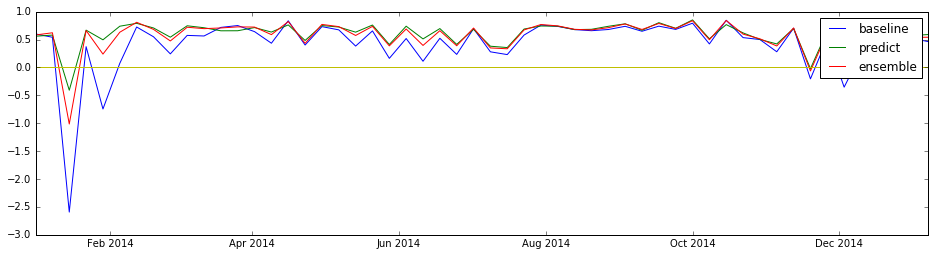

In [15]:
scores = score_df(trained)
plot_scores(scores)

In [16]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.658803471502
Ensemble:  0.647135372054
Baseline:  0.567501675452


### 2013

In [17]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2013, 1, 1)
last = datetime.date(2014, 1, 1)
pr5_13 = run_multiweek(grid, 3, 5, first, last, 7)


In [20]:
trained = get_trained(pr5_13)


2013-01-01 {'model': 0.56666457745196042, 'ensemble': 0.54041083415761082, 'baseline': 0.52714386334753927}
2013-01-08 {'model': 0.67429339395774568, 'ensemble': 0.61662892614862286, 'baseline': 0.47259260150913907}
2013-01-15 {'model': -0.15165974132370064, 'ensemble': -0.68428041134989193, 'baseline': -1.8850609304386472}
2013-01-22 {'model': 0.74233813116489267, 'ensemble': 0.67282076212366981, 'baseline': 0.32466918146331902}
2013-01-29 {'model': 0.76724763816197683, 'ensemble': 0.74409167356389094, 'baseline': 0.59581230778019889}
2013-02-05 {'model': 0.62869094603814335, 'ensemble': 0.48590169232840608, 'baseline': 0.079662045097047329}
2013-02-12 {'model': 0.51770862580455579, 'ensemble': 0.60894529988670709, 'baseline': 0.70188772811611022}
2013-02-19 {'model': 0.66977960403046288, 'ensemble': 0.7168764352201229, 'baseline': 0.68959849078045421}
2013-02-26 {'model': 0.71615677654535226, 'ensemble': 0.74448181663302915, 'baseline': 0.71075124540121437}
2013-03-05 {'model': 0.711

In [21]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2013.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2013-1-1':'2014-1-1'])

Predict:  0.644350353164
Ensemble:  0.625386556163
Baseline:  0.588081465227


## 2012

In [22]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2012, 1, 1)
last = datetime.date(2013, 1, 1)
pr5_12 = run_multiweek(grid, 3, 5, first, last, 7)


In [25]:
trained = get_trained(pr5_12)


2012-01-01 {'model': 0.5298025726479445, 'ensemble': 0.42879821590740119, 'baseline': 0.34488557942283404}
2012-01-08 {'model': 0.57721747783408328, 'ensemble': 0.52679258727717482, 'baseline': 0.38230579834218859}
2012-01-15 {'model': 0.34730255045005287, 'ensemble': 0.26731327608950839, 'baseline': -0.082691595589748479}
2012-01-22 {'model': -0.30078152134245983, 'ensemble': -0.30168613914868181, 'baseline': -1.711013191878604}
2012-01-29 {'model': 0.65974858274518078, 'ensemble': 0.71478470653992154, 'baseline': 0.63535308330723983}
2012-02-05 {'model': 0.61324719789123261, 'ensemble': 0.62242977318680714, 'baseline': 0.5158700584755137}
2012-02-12 {'model': 0.67162001899163282, 'ensemble': 0.71024917956511557, 'baseline': 0.68062418521971102}
2012-02-19 {'model': 0.54248471810356347, 'ensemble': 0.66215979901079713, 'baseline': 0.73259316524039342}
2012-02-26 {'model': 0.55362202378717573, 'ensemble': 0.59395147721755248, 'baseline': 0.5992982632662649}
2012-03-04 {'model': 0.69434

In [26]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2012.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results[str(first):str(last)])

Predict:  0.6596242103
Ensemble:  0.668454304568
Baseline:  0.638736010706


## 2011

In [27]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2011, 1, 1)
last = datetime.date(2012, 1, 1)
pr5_11 = run_multiweek(grid, 3, 5, first, last, 7)


In [31]:
trained = get_trained(pr5_11)


2011-01-01 {'model': 0.2670449329849196, 'ensemble': 0.23470361405010187, 'baseline': 0.19097893951859679}
2011-01-08 {'model': 0.384998232499703, 'ensemble': 0.3508347746993763, 'baseline': 0.30767568454739591}
2011-01-15 {'model': 0.47112068123202411, 'ensemble': 0.46177742017361811, 'baseline': 0.0054857658411261445}
2011-01-22 {'model': 0.77280997409688412, 'ensemble': 0.61620674346674109, 'baseline': 0.14955566699351153}
2011-01-29 {'model': 0.50207288286564056, 'ensemble': 0.62913533732497495, 'baseline': 0.50084378983714828}
2011-02-05 {'model': 0.43665788473944722, 'ensemble': 0.41101207168902298, 'baseline': -0.25505327712290149}
2011-02-12 {'model': 0.40557646691135463, 'ensemble': 0.48844965818263386, 'baseline': 0.39856451023840656}
2011-02-19 {'model': 0.39328529023614422, 'ensemble': 0.55442685180371221, 'baseline': 0.68007739348383844}
2011-02-26 {'model': 0.3408420181253512, 'ensemble': 0.34074292018706864, 'baseline': 0.1580325048976936}
2011-03-05 {'model': 0.05097838

In [32]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_5_2011.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results[str(first):str(last)])

Predict:  0.553032113466
Ensemble:  0.568628421825
Baseline:  0.528303941688


## Peace Arch North
### 2015

In [8]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr2_15 = run_multiweek(grid, 4, 2, first, last, 7)


In [14]:
trained = get_trained(pr2_15)


2015-01-01 {'model': 0.27411999900252149, 'ensemble': 0.25854748871025313, 'baseline': 0.24588725100921349}
2015-01-08 {'model': 0.35940097453447373, 'ensemble': 0.24296253064396056, 'baseline': -0.29447035481332717}
2015-01-15 {'model': -3.4417398689403642, 'ensemble': -6.3960138543745657, 'baseline': -17.676242617906471}
2015-01-22 {'model': 0.22027114289711835, 'ensemble': -0.1840128115733568, 'baseline': -2.2937147386363241}
2015-01-29 {'model': -0.28977183749022539, 'ensemble': -1.4113574028589255, 'baseline': -6.1039907431967988}
2015-02-05 {'model': 0.33490822399117148, 'ensemble': -0.39583696611617514, 'baseline': -6.0129249650843448}
2015-02-12 {'model': 0.052959740409336042, 'ensemble': 0.13729978353803196, 'baseline': 0.185616186550698}
2015-02-19 {'model': 0.61293248220552143, 'ensemble': 0.62084161928159198, 'baseline': 0.47052649314694539}
2015-02-26 {'model': 0.35997498667150274, 'ensemble': 0.055359717639181016, 'baseline': -2.1050329409913529}
2015-03-05 {'model': 0.41

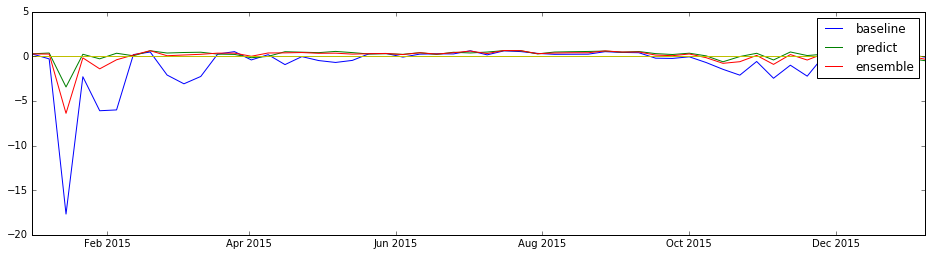

In [15]:
scores = score_df(trained)
plot_scores(scores)

In [16]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.387912343207
Ensemble:  0.374987110184
Baseline:  0.156649400704


### 2014

In [9]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr2_14 = run_multiweek(grid, 4, 2, first, last, 7)


In [17]:
trained = get_trained(pr2_14)


2014-01-01 {'model': 0.1737878234355551, 'ensemble': 0.21359546159039977, 'baseline': 0.2846019203831649}
2014-01-08 {'model': 0.34336414613151311, 'ensemble': 0.2996394288946892, 'baseline': -0.066511700242518845}
2014-01-15 {'model': 0.20766561557502439, 'ensemble': -0.19736596030127807, 'baseline': -2.0536563004383668}
2014-01-22 {'model': 0.3885535269521595, 'ensemble': 0.37568586225026634, 'baseline': -0.10127337629082156}
2014-01-29 {'model': 0.46708955654806583, 'ensemble': 0.45640909292631016, 'baseline': -0.011384522610143}
2014-02-05 {'model': 0.57369346755111972, 'ensemble': 0.60416617107545434, 'baseline': 0.39473376341777255}
2014-02-12 {'model': 0.29522445097873884, 'ensemble': 0.35336959557322412, 'baseline': 0.40936072708075932}
2014-02-19 {'model': 0.19514618242852766, 'ensemble': 0.26495638620426565, 'baseline': 0.2923734895558503}
2014-02-26 {'model': -0.20562918046729828, 'ensemble': -0.13351279198038424, 'baseline': -0.19645122487558386}
2014-03-05 {'model': 0.2430

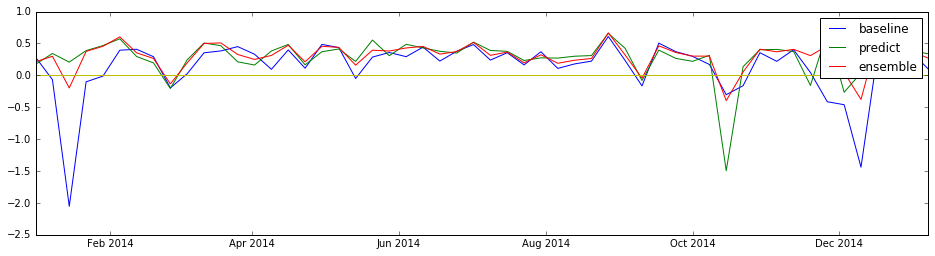

In [18]:
scores = score_df(trained)
plot_scores(scores)

In [19]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_2_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.406669704365
Ensemble:  0.407646758259
Baseline:  0.352064007063


## Pacific Highway North
### 2015

In [20]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2015, 1, 1)
last = datetime.date(2016, 1, 1)
pr6_15 = run_multiweek(grid, 4, 6, first, last, 7)


In [22]:
trained = get_trained(pr6_15)


2015-01-01 {'model': 0.29119757498149512, 'ensemble': 0.2644985855760239, 'baseline': 0.24731975974500331}
2015-01-08 {'model': 0.37741904836836426, 'ensemble': 0.24593495709066249, 'baseline': -0.50325865101347356}
2015-01-15 {'model': -0.52010003095124868, 'ensemble': -1.3549631688582973, 'baseline': -5.0620393827105836}
2015-01-22 {'model': -0.50205478044669505, 'ensemble': -1.0956213613336385, 'baseline': -3.836788130531299}
2015-01-29 {'model': -0.11770870852434845, 'ensemble': -0.65776665442712101, 'baseline': -3.1880409767712141}
2015-02-05 {'model': -0.12768919819528346, 'ensemble': -1.0394624837550102, 'baseline': -6.123834058095297}
2015-02-12 {'model': 0.18872177018823655, 'ensemble': 0.26980954726085404, 'baseline': 0.16049673091068295}
2015-02-19 {'model': 0.44206132702163092, 'ensemble': 0.48068720348630312, 'baseline': 0.32699700229839124}
2015-02-26 {'model': 0.084877236387598254, 'ensemble': -0.57716590122926648, 'baseline': -4.1260635132519923}
2015-03-05 {'model': 0.

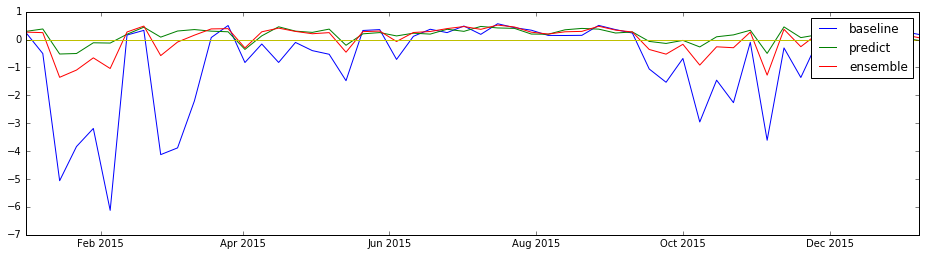

In [23]:
scores = score_df(trained)
plot_scores(scores)

In [24]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_6_2015.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2015-1-1':'2016-1-1'])

Predict:  0.317148167136
Ensemble:  0.312591681355
Baseline:  0.0599474525624


### 2014

In [21]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96)
grid = GridSearchCV(model, {})

first = datetime.date(2014, 1, 1)
last = datetime.date(2015, 1, 1)
pr6_14 = run_multiweek(grid, 4, 6, first, last, 7)


In [25]:
trained = get_trained(pr6_14)


2014-01-01 {'model': 0.20516542425072726, 'ensemble': 0.21987556940988173, 'baseline': 0.24205713067569923}
2014-01-08 {'model': 0.15208407340764951, 'ensemble': 0.10162531619432669, 'baseline': -0.17987725304083924}
2014-01-15 {'model': -0.045560547650091099, 'ensemble': -0.061359326084593935, 'baseline': -0.67614686974584948}
2014-01-22 {'model': 0.24262487362781138, 'ensemble': 0.27877769369483985, 'baseline': 0.052369393131533437}
2014-01-29 {'model': 0.28986836759892165, 'ensemble': 0.35303473122063456, 'baseline': 0.033443284452879252}
2014-02-05 {'model': 0.37512253519845107, 'ensemble': 0.44051184016790235, 'baseline': 0.45271162843428603}
2014-02-12 {'model': 0.23674490467785281, 'ensemble': 0.31406728870866152, 'baseline': 0.38664166160386459}
2014-02-19 {'model': 0.26254463706925102, 'ensemble': 0.38627438968809968, 'baseline': 0.50501892372799229}
2014-02-26 {'model': -0.070690024793570672, 'ensemble': 0.066686065311185483, 'baseline': 0.073835768523976109}
2014-03-05 {'mod

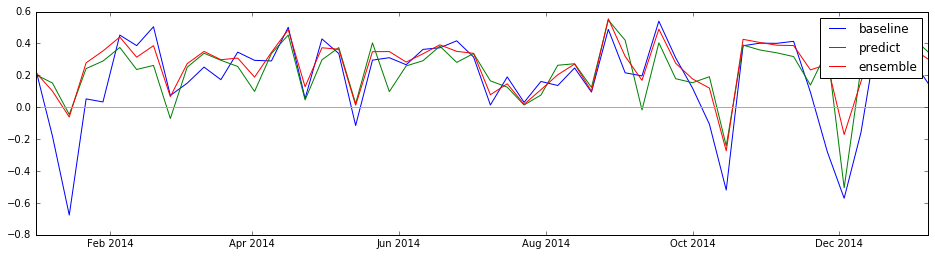

In [26]:
scores = score_df(trained)
plot_scores(scores)

In [27]:
results = results_df(trained)
with open('/home/ubuntu/BorderCrossing/data/results_6_2014.pkl', 'w') as f:
    pickle.dump(results, f)

print_r2(results['2014-1-1':'2015-1-1'])

Predict:  0.330033886585
Ensemble:  0.344684354916
Baseline:  0.316148475447
